In [28]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pylab as plt

### Loading the data which we proccesed in the SARIMA Script

In [29]:
df = pd.read_excel('./output/df_out.xlsx')

In [30]:
df.head()

,ds,y
0,2011-01-02,290.666
1,2011-01-03,2203.151
2,2011-01-04,119.888
3,2011-01-05,2654.204
4,2011-01-06,5188.520


<Axes: xlabel='ds'>

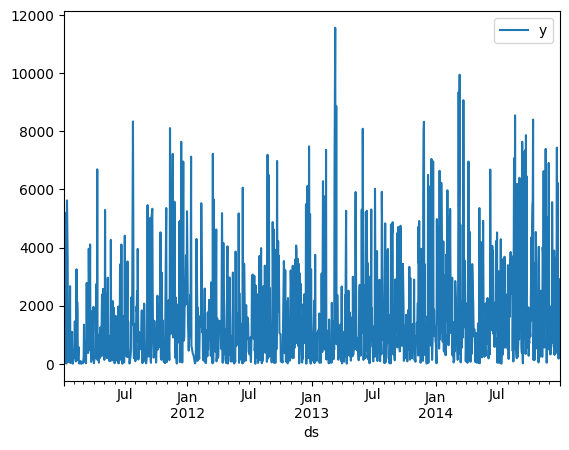

In [31]:
df.set_index("ds").plot()

### Train/Test Split

In [32]:
forecast_steps = 31
train = df[:-forecast_steps]
test = df[-forecast_steps:]

In [33]:
test.head()

,ds,y
1429,2014-12-01,866.702
1430,2014-12-02,1241.516
1431,2014-12-03,1973.708
1432,2014-12-04,319.806
1433,2014-12-05,449.469


#### Adding Holidays to see the affect in Prophet. At very first place Ran without the Holidays

In [34]:
holiday_names = [
    'new_year', 'mlk_day', 'presidents_day', 'memorial_day',
    'juneteenth', 'independence_day', 'labor_day', 'columbus_day',
    'veterans_day', 'thanksgiving', 'christmas'
]

holiday_dates = [
    '2011-01-01', '2011-01-17', '2011-02-21', '2011-05-30',
    '2011-06-19', '2011-07-04', '2011-09-05', '2011-10-10',
    '2011-11-11', '2011-11-24', '2011-12-25',

    '2012-01-01', '2012-01-16', '2012-02-20', '2012-05-28',
    '2012-06-19', '2012-07-04', '2012-09-03', '2012-10-08',
    '2012-11-11', '2012-11-22', '2012-12-25',

    '2013-01-01', '2013-01-21', '2013-02-18', '2013-05-27',
    '2013-06-19', '2013-07-04', '2013-09-02', '2013-10-14',
    '2013-11-11', '2013-11-28', '2013-12-25',

    '2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26',
    '2014-06-19', '2014-07-04', '2014-09-01', '2014-10-13',
    '2014-11-11', '2014-11-27', '2014-12-25'
]

holiday_labels = holiday_names * 4 

s_holidays = pd.DataFrame({
    'holiday': holiday_labels,
    'ds': pd.to_datetime(holiday_dates),
    'lower_window': 0,
    'upper_window': 1
})



In [35]:
s_holidays.head()

,holiday,ds,lower_window,upper_window
0,new_year,2011-01-01,0,1
1,mlk_day,2011-01-17,0,1
2,presidents_day,2011-02-21,0,1
3,memorial_day,2011-05-30,0,1
4,juneteenth,2011-06-19,0,1


### Model Init and fit

In [36]:
model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1,
    holidays= s_holidays
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train)

03:51:28 - cmdstanpy - INFO - Chain [1] start processing
03:51:29 - cmdstanpy - INFO - Chain [1] done processing


### This model was doing quiet well so ran for 360 day

In [37]:
future = model.make_future_dataframe(periods=360) #forecast_steps

In [38]:
forecast = model.predict(future)

In [39]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1784,2015-11-21,3254.590707,1113.399081,5293.561523
1785,2015-11-22,3157.732644,993.279831,5290.319096
1786,2015-11-23,3374.882336,1260.552425,5403.915966
1787,2015-11-24,3148.391957,1209.368794,5153.660946
1788,2015-11-25,2707.743225,594.098217,4857.524483


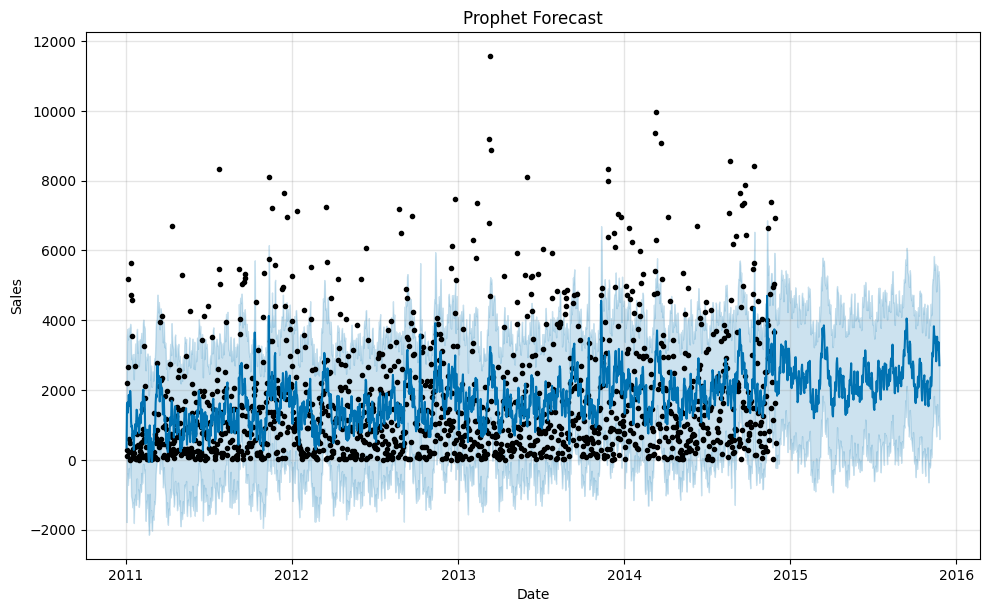

In [40]:
model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

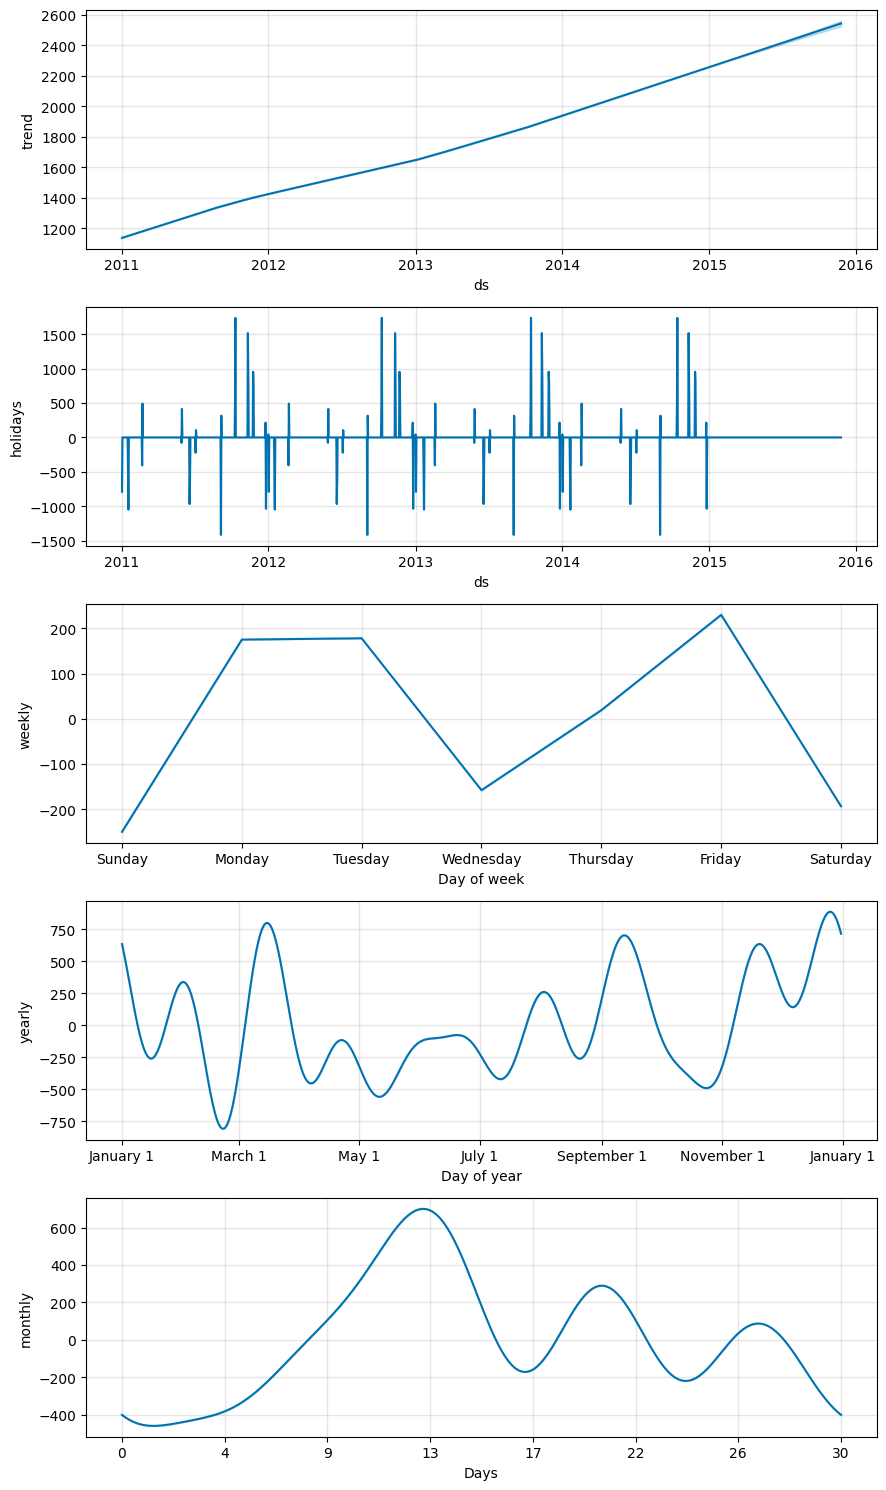

In [41]:
model.plot_components(forecast)
plt.show()

In [42]:
forecast_test = forecast.set_index('ds').loc[test['ds']]

### Model Accuracy

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))

print("Prophet MAE:", mae)
print("Prophet RMSE:", rmse)

Prophet MAE: 1471.3410984158586
Prophet RMSE: 1776.7520160072145


### plot against actual vs forcast

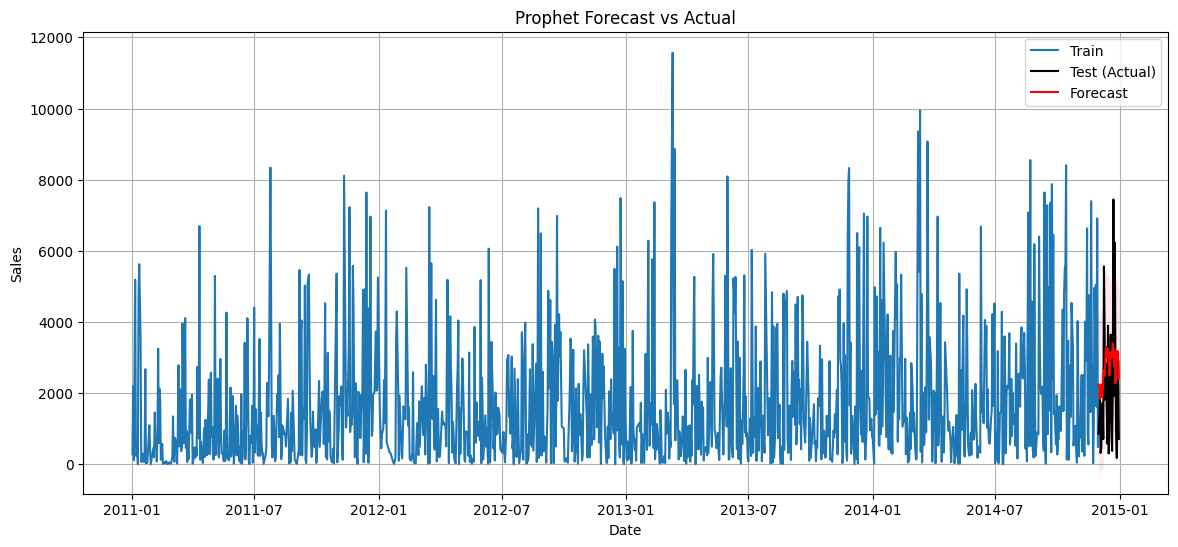

In [44]:
plt.figure(figsize=(14,6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test (Actual)', color='black')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Forecast', color='red')

plt.fill_between(
    forecast_test.index,
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    color='pink', alpha=0.3
)

plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()